In [21]:
import os
from datetime import datetime, timedelta, timezone
from skyfield.api import load, Topos, EarthSatellite
import matplotlib.pyplot as plt

# all satellite TLE directory
directory = 'TLE_data/'
output_file = "Starlink_TLE/TLE_history.txt"

In [22]:
def parse_tle_epoch(epoch):
    year = int(epoch[:2])
    if year < 57:
        year += 2000
    else:
        year += 1900
    day_of_year = float(epoch[2:])
    day = int(day_of_year)
    fractional_day = day_of_year - day
    date = datetime(year, 1, 1, tzinfo=timezone.utc) + timedelta(days=day - 1)
    time_of_day = timedelta(days=fractional_day)
    return date + time_of_day



# checj if TLE in the time range
def is_tle_in_date_range(tle, start_date, end_date):
    epoch = tle.split()[3]
    tle_time = parse_tle_epoch(epoch)
    return start_date <= tle_time <= end_date

In [23]:
def get_latest_tle(tle_list, target_time):
    latest_tle = None
    latest_time = None
    for tle in tle_list:
        epoch = tle.split()[4]
        #print(epoch)
        tle_time = parse_tle_epoch(epoch)
        if tle_time <= target_time:
            if latest_time is None or tle_time > latest_time:
                latest_tle = tle
                latest_time = tle_time
    return latest_tle

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [25]:
# load tle data and order by time
document_file = 'Starlink_TLE/Single_Satellite_TLE'
satellite_name = 'STARLINK-1094'
tle_file = os.path.join(document_file, f'{satellite_name}.txt')
tle_data = []

with open(tle_file, 'r') as file:
    lines = file.readlines()
    i = 0
    while i < len(lines):
        if lines[i].startswith(satellite_name):
            tle1 = lines[i+1].strip()
            tle2 = lines[i+2].strip()
            tle_epoch = parse_tle_epoch(tle1.split()[3])
            tle_data.append((tle_epoch, tle1, tle2))
            i += 3
        else:
            i += 1

tle_data.sort(key=lambda x: x[0])  # 按历元时间排序

In [26]:
# gemerate time series
start_time = datetime(2023, 12, 31, 23, 0, 0, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 1, 2, 0, 0, tzinfo=timezone.utc)
time_step = timedelta(minutes = 0.5)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

In [27]:
# 计算每个时间点的卫星海拔
ts = load.timescale()
altitudes = []
latutudes = []
longitudes = []
times = []

tle_index = 0

for current_time in time_series:
    # 更新TLE数据
    while tle_index < len(tle_data) - 1 and tle_data[tle_index + 1][0] <= current_time:
        tle_index += 1

    latest_tle = tle_data[tle_index]
    # 计算海拔
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()
   
    altitude = subpoint.elevation.km
    altitudes.append(altitude)
    
    latitude = subpoint.latitude.degrees
    latutudes.append(latitude)

    
    longitude = subpoint.longitude.degrees
    longitudes.append(longitude)

    
    times.append(current_time)

C:\Users\ycgao\AppData\Local\Temp\ipykernel_23608\289260435.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


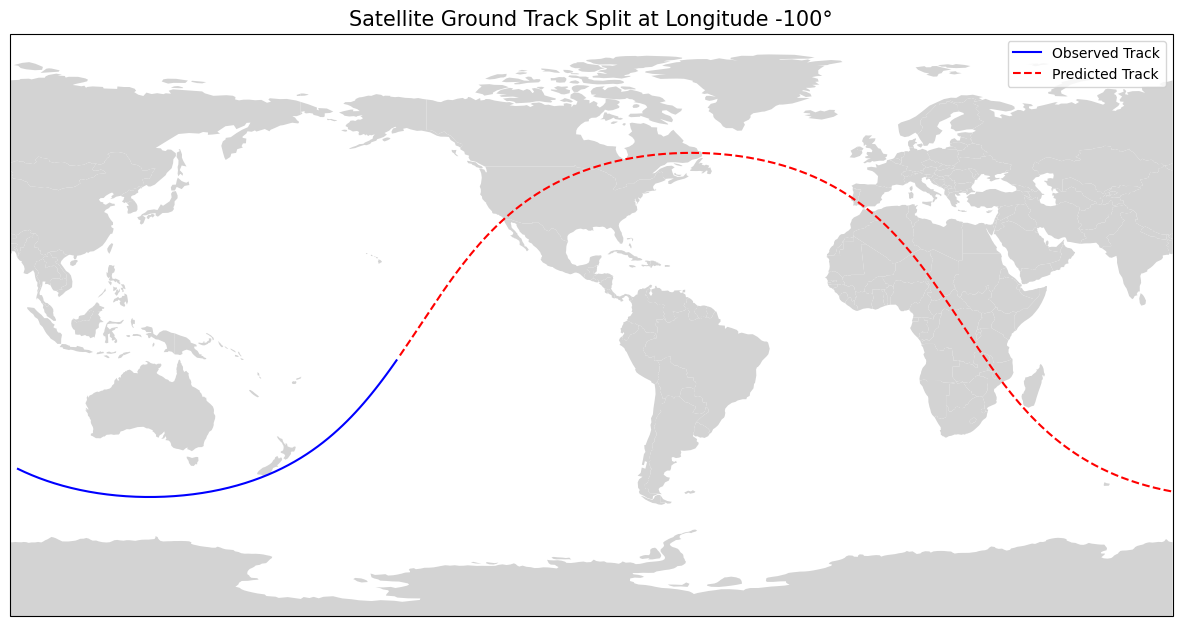

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming latitudes, longitudes, and times have been computed as in your code

# Load the world map using GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Adjust longitudes to account for the new map center at -90 degrees
adjusted_longitudes = [(lon - 360)+90 if lon > 90 else lon+90 for lon in longitudes]

# Initialize lists for filtered latitudes and longitudes
tracks = []

# Loop to find a segment where the satellite moves from left to right (increasing adjusted longitude)
for i in range(1, len(adjusted_longitudes)):
    if adjusted_longitudes[i] > adjusted_longitudes[i - 1]:
        if adjusted_longitudes[i] <= -60:  # Corresponds to original longitude -100 adjusted by +360
            filtered_latitudes_observed.append(latutudes[i])
            filtered_longitudes_observed.append(longitudes[i])
        else:  # Predicted track after original longitude -100 adjusted
            filtered_latitudes_predicted.append(latutudes[i])
            filtered_longitudes_predicted.append(longitudes[i])
    else:
        # Check if both observed and predicted segments are non-empty and reset if needed
        if len(filtered_longitudes_observed) == 0 or filtered_longitudes_observed[0]+90-360 > -170:
            filtered_latitudes_observed = []
            filtered_longitudes_observed = []
            filtered_latitudes_predicted = []
            filtered_longitudes_predicted = []
        else:
            break

# Create a figure and axis with a Cartopy projection centered on -90 degrees (Americas)
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-90)})

# Plot the world map using GeoPandas with the specified projection
world.plot(ax=ax, color='lightgrey', transform=ccrs.PlateCarree())

# Plot the observed satellite ground track
ax.plot(filtered_longitudes_observed, filtered_latitudes_observed, color='blue', linewidth=1.5, label='Observed Track', transform=ccrs.Geodetic())

# Plot the predicted satellite ground track
ax.plot(filtered_longitudes_predicted, filtered_latitudes_predicted, color='red', linewidth=1.5, linestyle='--', label='Predicted Track', transform=ccrs.Geodetic())

# Add coastlines and gridlines for better context
#ax.coastlines()
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Add title and labels
ax.set_title('Satellite Ground Track Split at Longitude -100°', fontsize=15)
ax.legend()

# Show the plot
plt.show()


In [29]:
from model.distribution_efficiency_stat2sat import communication_loss_stat2sat_coordinate

In [30]:
ground_stations = {
    "Ottawa": {"latitude": 45.4215, "longitude": -75.6972, "continent": "North America"},
    "Brussels": {"latitude": 50.8503, "longitude": 4.3517, "continent": "Europe"},
    "Paris": {"latitude": 48.8566, "longitude": 2.3522, "continent": "Europe"},
    "Berlin": {"latitude": 52.5200, "longitude": 13.4050, "continent": "Europe"},
    "Amsterdam": {"latitude": 52.3676, "longitude": 4.9041, "continent": "Europe"},
    "London": {"latitude": 51.5074, "longitude": -0.1278, "continent": "Europe"},
    "Washington D.C.": {"latitude": 38.9072, "longitude": -77.0369, "continent": "North America"},
    "New York": {"latitude": 40.7128, "longitude": -74.0060, "continent": "North America"},
    "Chicago": {"latitude": 41.8781, "longitude": -87.6298, "continent": "North America"},
    "Los Angeles": {"latitude": 34.0522, "longitude": -118.2437, "continent": "North America"}
}

In [31]:
# gemerate time series
start_time = datetime(2023, 12, 31, 23, 0, 0, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 1, 2, 0, 0, tzinfo=timezone.utc)
time_step = timedelta(seconds = 1)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

In [32]:
tle_index

2775

In [33]:
# 计算每个时间点的卫星海拔
ts = load.timescale()
satellite_altitudes = []
satellite_latutudes = []
satellite_longitudes = []
etas = []
times = []

station_altitude = 0
station_latitude = ground_stations["New York"]['latitude']
station_longitude = ground_stations["New York"]['longitude']

tle_index = 0

for current_time in time_series:
    # 更新TLE数据
    while tle_index < len(tle_data) - 1 and tle_data[tle_index + 1][0] <= current_time:
        tle_index += 1

    latest_tle = tle_data[tle_index]
    # 计算海拔
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()
   
    satellite_altitude = subpoint.elevation.km
    satellite_altitudes.append(satellite_altitude)
    
    satellite_latitude = subpoint.latitude.degrees
    satellite_latutudes.append(satellite_latitude)

    
    satellite_longitude = subpoint.longitude.degrees
    satellite_longitudes.append(satellite_longitude)

    eta = communication_loss_stat2sat_coordinate(station_latitude, station_longitude, station_altitude, satellite_latitude, satellite_longitude, satellite_altitude)
    etas.append(eta)
    
    times.append(current_time)

C:\Users\ycgao\AppData\Local\Temp\ipykernel_23608\1125437341.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


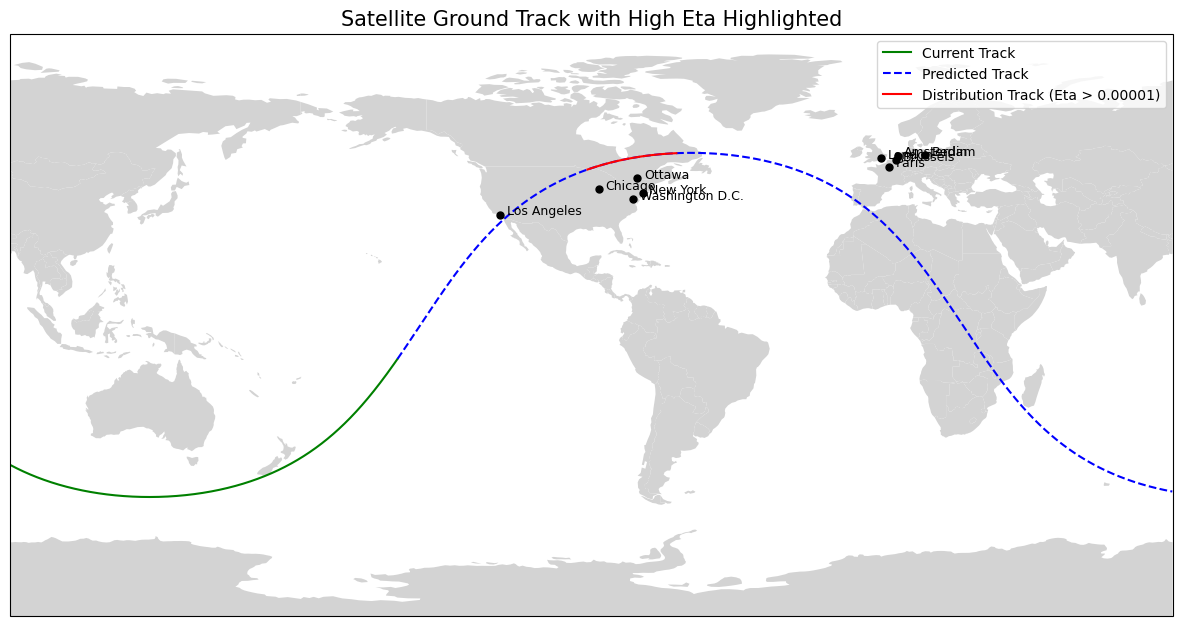

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load the world map using GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Adjust longitudes to account for the new map center at -90 degrees
adjusted_longitudes = [(lon - 360) + 90 if lon > 90 else lon + 90 for lon in satellite_longitudes]

# Initialize lists for filtered latitudes and longitudes
filtered_latitudes_observed = []
filtered_longitudes_observed = []
filtered_latitudes_predicted = []
filtered_longitudes_predicted = []
filtered_latitudes_distribution = []
filtered_longitudes_distribution = []

# Loop to find a segment where the satellite moves from left to right (increasing adjusted longitude)
for i in range(1, len(adjusted_longitudes)):
    if adjusted_longitudes[i] > adjusted_longitudes[i - 1]:
        if adjusted_longitudes[i] <= -60:  # Corresponds to original longitude -100 adjusted by +360
            filtered_latitudes_observed.append(satellite_latutudes[i])
            filtered_longitudes_observed.append(satellite_longitudes[i])
            # Check for high eta and append to respective lists for distribution track
            if etas[i] > 0.0001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
        else:  # Predicted track after original longitude -100 adjusted
            filtered_latitudes_predicted.append(satellite_latutudes[i])
            filtered_longitudes_predicted.append(satellite_longitudes[i])
            # Check for high eta and append to respective lists for distribution track
            if etas[i] > 0.0001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
    else:
        # Check if both observed and predicted segments are non-empty and reset if needed
        if len(filtered_longitudes_observed) == 0 or filtered_longitudes_observed[0] + 90 - 360 > -170:
            filtered_latitudes_observed = []
            filtered_longitudes_observed = []
            filtered_latitudes_predicted = []
            filtered_longitudes_predicted = []
            filtered_latitudes_distribution = []
            filtered_longitudes_distribution = []
        else:
            break

# Create a figure and axis with a Cartopy projection centered on -90 degrees (Americas)
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-90)})

# Plot the world map using GeoPandas with the specified projection
world.plot(ax=ax, color='lightgrey', transform=ccrs.PlateCarree())

# Plot the current satellite ground track (blue solid line)
ax.plot(filtered_longitudes_observed, filtered_latitudes_observed, color='green', linewidth=1.5, label='Current Track', transform=ccrs.Geodetic())

# Plot the predicted satellite ground track (yellow dashed line)
ax.plot(filtered_longitudes_predicted, filtered_latitudes_predicted, color='blue', linewidth=1.5, linestyle='--', label='Predicted Track', transform=ccrs.Geodetic())

# Plot the distribution track (where eta > 0.00001) as a red solid line
ax.plot(filtered_longitudes_distribution, filtered_latitudes_distribution, color='red', linewidth=1.5, label='Distribution Track (Eta > 0.00001)', transform=ccrs.Geodetic())

# Plot the ground stations
for station, data in ground_stations.items():
    ax.plot(data['longitude'], data['latitude'], marker='o', color='black', markersize=5, transform=ccrs.PlateCarree())
    ax.text(data['longitude'] + 2, data['latitude'], station, transform=ccrs.PlateCarree(), fontsize=9)
    

# Add title and labels
ax.set_title('Satellite Ground Track with High Eta Highlighted', fontsize=15)
ax.legend()

# Show the plot
plt.show()


C:\Users\ycgao\AppData\Local\Temp\ipykernel_23608\1637484324.py:84: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


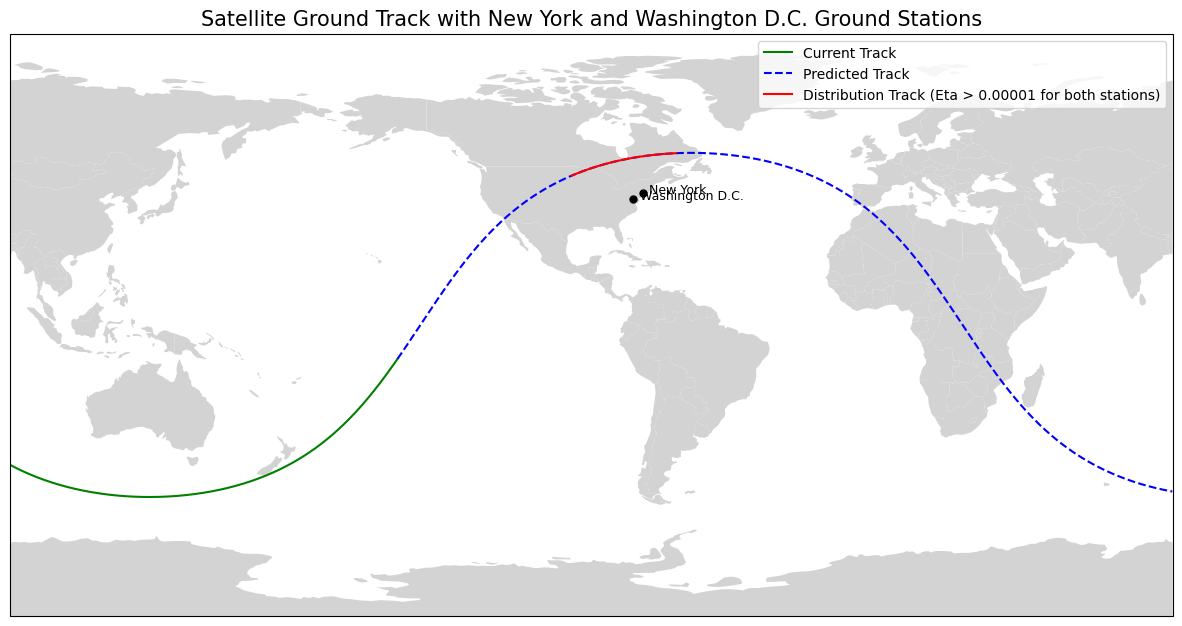

In [35]:
# Define the ground stations with coordinates and continent
ground_stations = {
    "New York": {"latitude": 40.7128, "longitude": -74.0060, "continent": "North America"},
    "Washington D.C.": {"latitude": 38.9072, "longitude": -77.0369, "continent": "North America"},
}

# Calculate etas for both New York and Washington D.C.
station1 = ground_stations["New York"]
station2 = ground_stations["Washington D.C."]

# Initialize lists for etas
etas_new_york = []
etas_washington_dc = []

# Calculate etas based on both ground stations
for i, current_time in enumerate(times):
    # Update TLE data (as already computed)
    latest_tle = tle_data[tle_index]
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()

    satellite_altitude = subpoint.elevation.km
    satellite_latitude = subpoint.latitude.degrees
    satellite_longitude = subpoint.longitude.degrees

    # Calculate etas for New York
    eta_ny = communication_loss_stat2sat_coordinate(
        station1['latitude'], station1['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_new_york.append(eta_ny)

    # Calculate etas for Washington D.C.
    eta_dc = communication_loss_stat2sat_coordinate(
        station2['latitude'], station2['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_washington_dc.append(eta_dc)

# Adjust longitudes to account for the new map center at -90 degrees
adjusted_longitudes = [(lon - 360) + 90 if lon > 90 else lon + 90 for lon in satellite_longitudes]

# Initialize lists for filtered latitudes and longitudes
filtered_latitudes_observed = []
filtered_longitudes_observed = []
filtered_latitudes_predicted = []
filtered_longitudes_predicted = []
filtered_latitudes_distribution = []
filtered_longitudes_distribution = []

# Loop to find a segment where the satellite moves from left to right (increasing adjusted longitude)
for i in range(1, len(adjusted_longitudes)):
    if adjusted_longitudes[i] > adjusted_longitudes[i - 1]:
        if adjusted_longitudes[i] <= -60:  # Corresponds to original longitude -100 adjusted by +360
            filtered_latitudes_observed.append(satellite_latutudes[i])
            filtered_longitudes_observed.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
        else:  # Predicted track after original longitude -100 adjusted
            filtered_latitudes_predicted.append(satellite_latutudes[i])
            filtered_longitudes_predicted.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
    else:
        # Check if both observed and predicted segments are non-empty and reset if needed
        if len(filtered_longitudes_observed) == 0 or filtered_longitudes_observed[0] + 90 - 360 > -170:
            filtered_latitudes_observed = []
            filtered_longitudes_observed = []
            filtered_latitudes_predicted = []
            filtered_longitudes_predicted = []
            filtered_latitudes_distribution = []
            filtered_longitudes_distribution = []
        else:
            break

# Create a figure and axis with a Cartopy projection centered on -90 degrees (Americas)
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-90)})

# Plot the world map using GeoPandas with the specified projection
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', transform=ccrs.PlateCarree())

# Plot the current satellite ground track (blue solid line)
ax.plot(filtered_longitudes_observed, filtered_latitudes_observed, color='green', linewidth=1.5, label='Current Track', transform=ccrs.Geodetic())

# Plot the predicted satellite ground track (yellow dashed line)
ax.plot(filtered_longitudes_predicted, filtered_latitudes_predicted, color='blue', linewidth=1.5, linestyle='--', label='Predicted Track', transform=ccrs.Geodetic())

# Plot the distribution track (where eta > 0.00001 for both stations) as a red solid line
ax.plot(filtered_longitudes_distribution, filtered_latitudes_distribution, color='red', linewidth=1.5, label='Distribution Track (Eta > 0.00001 for both stations)', transform=ccrs.Geodetic())

# Plot only New York and Washington D.C. ground stations
for station in ["New York", "Washington D.C."]:
    data = ground_stations[station]
    ax.plot(data['longitude'], data['latitude'], marker='o', color='black', markersize=5, transform=ccrs.PlateCarree())
    ax.text(data['longitude'] + 2, data['latitude'], station, transform=ccrs.PlateCarree(), fontsize=9)

# Add title and labels
ax.set_title('Satellite Ground Track with New York and Washington D.C. Ground Stations', fontsize=15)
ax.legend()

# Show the plot
plt.show()

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from skyfield.api import load, EarthSatellite

# Define the ground stations with coordinates and continent
ground_stations = {
    "New York": {"latitude": 40.7128, "longitude": -74.0060, "continent": "North America"},
    "Washington D.C.": {"latitude": 38.9072, "longitude": -77.0369, "continent": "North America"},
}

# Calculate etas for both New York and Washington D.C.
station1 = ground_stations["New York"]
station2 = ground_stations["Washington D.C."]

# Initialize lists for etas
etas_new_york = []
etas_washington_dc = []

# Calculate etas based on both ground stations
for i, current_time in enumerate(times):
    # Update TLE data (as already computed)
    latest_tle = tle_data[tle_index]
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()

    satellite_altitude = subpoint.elevation.km
    satellite_latitude = subpoint.latitude.degrees
    satellite_longitude = subpoint.longitude.degrees

    # Calculate etas for New York
    eta_ny = communication_loss_stat2sat_coordinate(
        station1['latitude'], station1['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_new_york.append(eta_ny)

    # Calculate etas for Washington D.C.
    eta_dc = communication_loss_stat2sat_coordinate(
        station2['latitude'], station2['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_washington_dc.append(eta_dc)

# Adjust longitudes to account for the new map center at -90 degrees
adjusted_longitudes = [(lon - 360) + 90 if lon > 90 else lon + 90 for lon in satellite_longitudes]

# Initialize lists for filtered latitudes and longitudes
filtered_latitudes_observed = []
filtered_longitudes_observed = []
filtered_latitudes_predicted = []
filtered_longitudes_predicted = []
filtered_latitudes_distribution = []
filtered_longitudes_distribution = []

# Loop to find a segment where the satellite moves from left to right (increasing adjusted longitude)
for i in range(1, len(adjusted_longitudes)):
    if adjusted_longitudes[i] > adjusted_longitudes[i - 1]:
        if adjusted_longitudes[i] <= -60:  # Corresponds to original longitude -100 adjusted by +360
            filtered_latitudes_observed.append(satellite_latutudes[i])
            filtered_longitudes_observed.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
        else:  # Predicted track after original longitude -100 adjusted
            filtered_latitudes_predicted.append(satellite_latutudes[i])
            filtered_longitudes_predicted.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
    else:
        # Check if both observed and predicted segments are non-empty and reset if needed
        if len(filtered_longitudes_observed) == 0 or filtered_longitudes_observed[0] + 90 - 360 > -170:
            filtered_latitudes_observed = []
            filtered_longitudes_observed = []
            filtered_latitudes_predicted = []
            filtered_longitudes_predicted = []
            filtered_latitudes_distribution = []
            filtered_longitudes_distribution = []
        else:
            break




C:\Users\ycgao\AppData\Local\Temp\ipykernel_23608\767615991.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


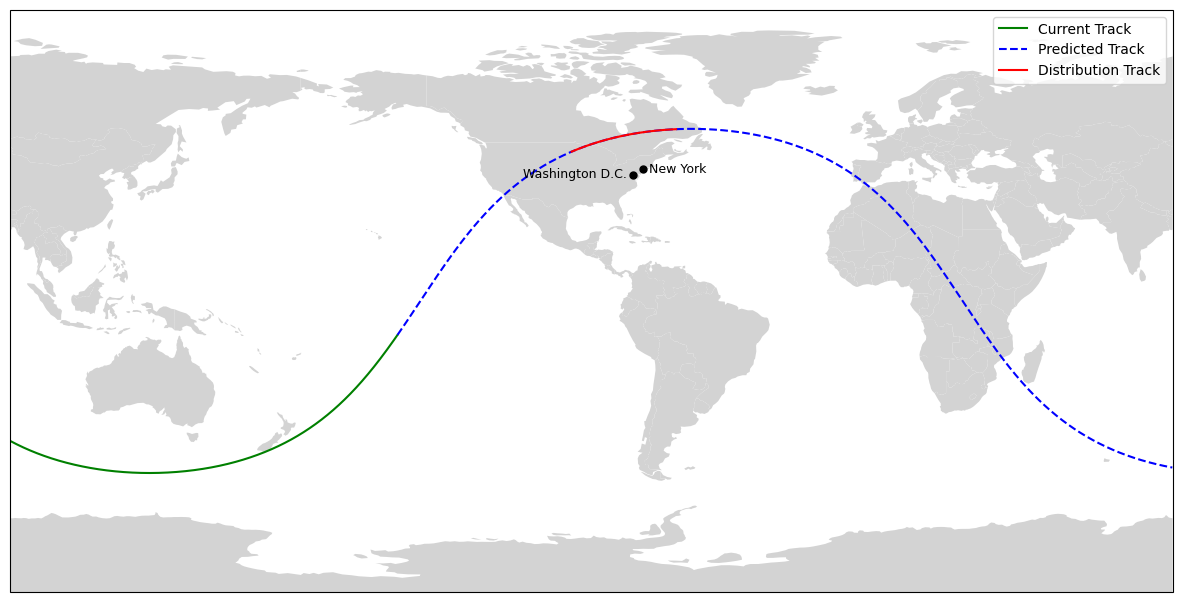

In [37]:
# Create a figure and axis with a Cartopy projection centered on -90 degrees (Americas)
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-90)})

# Plot the world map using GeoPandas with the specified projection
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', transform=ccrs.PlateCarree())

# Plot the current satellite ground track (blue solid line)
ax.plot(filtered_longitudes_observed, filtered_latitudes_observed, color='green', linewidth=1.5, label='Current Track', transform=ccrs.Geodetic())

# Plot the predicted satellite ground track (yellow dashed line)
ax.plot(filtered_longitudes_predicted, filtered_latitudes_predicted, color='blue', linewidth=1.5, linestyle='--', label='Predicted Track', transform=ccrs.Geodetic())

# Plot the distribution track (where eta > 0.00001 for both stations) as a red solid line
ax.plot(filtered_longitudes_distribution, filtered_latitudes_distribution, color='red', linewidth=1.5, label='Distribution Track', transform=ccrs.Geodetic())

# Plot only New York and Washington D.C. ground stations and adjust labels
ax.plot(station1['longitude'], station1['latitude'], marker='o', color='black', markersize=5, transform=ccrs.PlateCarree())
ax.text(station1['longitude'] + 2, station1['latitude'] - 1, "New York", transform=ccrs.PlateCarree(), fontsize=9, ha='left')

ax.plot(station2['longitude'], station2['latitude'], marker='o', color='black', markersize=5, transform=ccrs.PlateCarree())
ax.text(station2['longitude'] - 2, station2['latitude'] - 1, "Washington D.C.", transform=ccrs.PlateCarree(), fontsize=9, ha='right')

# Add title and labels
#ax.set_title('Satellite Ground Track with New York and Washington D.C. Ground Stations', fontsize=15)
ax.legend()

# Show the plot
plt.show()

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.image import imread
import numpy as np
# Load the custom icons
ground_station_icon = imread('ground_station_icon.png')
satellite_icon = imread('satellite_icon.png')

# Define the ground stations with coordinates and continent
ground_stations = {
    "New York": {"latitude": 40.7128, "longitude": -74.0060, "continent": "North America"},
    "Washington D.C.": {"latitude": 38.9072, "longitude": -77.0369, "continent": "North America"},
}

# Calculate etas for both New York and Washington D.C.
station1 = ground_stations["New York"]
station2 = ground_stations["Washington D.C."]

# Initialize lists for etas
etas_new_york = []
etas_washington_dc = []

# Calculate etas based on both ground stations
for i, current_time in enumerate(times):
    # Update TLE data (as already computed)
    latest_tle = tle_data[tle_index]
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()

    satellite_altitude = subpoint.elevation.km
    satellite_latitude = subpoint.latitude.degrees
    satellite_longitude = subpoint.longitude.degrees

    # Calculate etas for New York
    eta_ny = communication_loss_stat2sat_coordinate(
        station1['latitude'], station1['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_new_york.append(eta_ny)

    # Calculate etas for Washington D.C.
    eta_dc = communication_loss_stat2sat_coordinate(
        station2['latitude'], station2['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_washington_dc.append(eta_dc)

# Adjust longitudes to account for the new map center at -90 degrees
adjusted_longitudes = [(lon - 360) + 90 if lon > 90 else lon + 90 for lon in satellite_longitudes]

# Initialize lists for filtered latitudes and longitudes
filtered_latitudes_observed = []
filtered_longitudes_observed = []
filtered_latitudes_predicted = []
filtered_longitudes_predicted = []
filtered_latitudes_distribution = []
filtered_longitudes_distribution = []

# Loop to find a segment where the satellite moves from left to right (increasing adjusted longitude)
for i in range(1, len(adjusted_longitudes)):
    if adjusted_longitudes[i] > adjusted_longitudes[i - 1]:
        if adjusted_longitudes[i] <= -60:  # Corresponds to original longitude -100 adjusted by +360
            filtered_latitudes_observed.append(satellite_latutudes[i])
            filtered_longitudes_observed.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
        else:  # Predicted track after original longitude -100 adjusted
            filtered_latitudes_predicted.append(satellite_latutudes[i])
            filtered_longitudes_predicted.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
    else:
        # Check if both observed and predicted segments are non-empty and reset if needed
        if len(filtered_longitudes_observed) == 0 or filtered_longitudes_observed[0] + 90 - 360 > -170:
            filtered_latitudes_observed = []
            filtered_longitudes_observed = []
            filtered_latitudes_predicted = []
            filtered_longitudes_predicted = []
            filtered_latitudes_distribution = []
            filtered_longitudes_distribution = []
        else:
            break



C:\Users\ycgao\AppData\Local\Temp\ipykernel_23608\2156048631.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


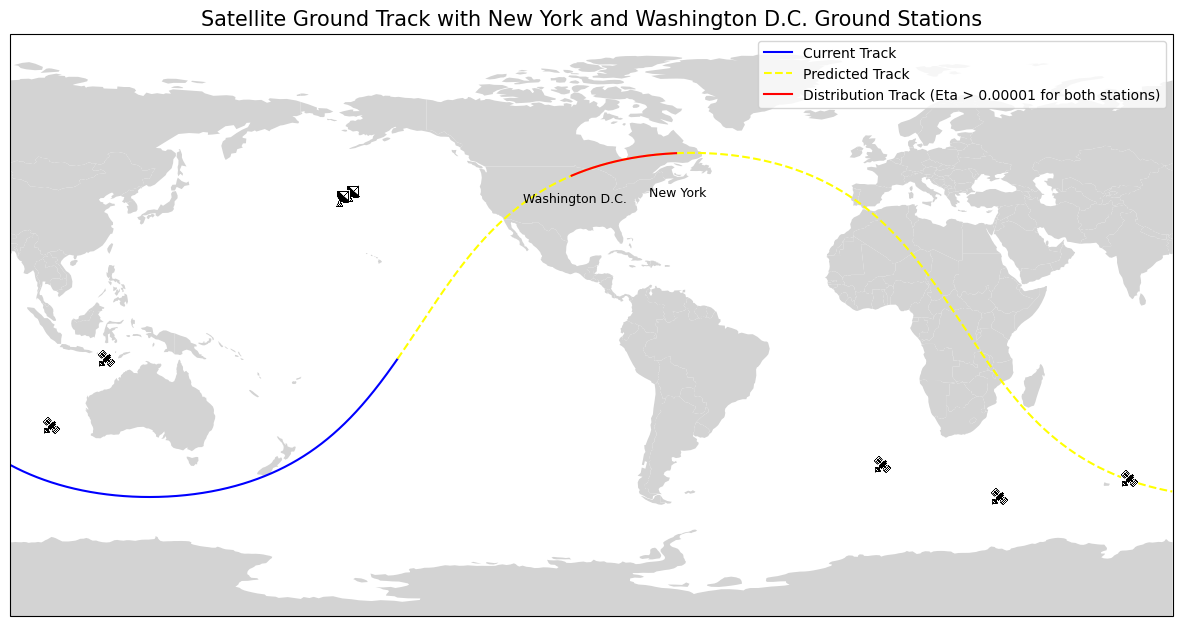

In [39]:
# Create a figure and axis with a Cartopy projection centered on -90 degrees (Americas)
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-90)})

# Plot the world map using GeoPandas with the specified projection
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', transform=ccrs.PlateCarree())

# Plot the current satellite ground track (blue solid line)
ax.plot(filtered_longitudes_observed, filtered_latitudes_observed, color='blue', linewidth=1.5, label='Current Track', transform=ccrs.Geodetic())

# Plot the predicted satellite ground track (yellow dashed line)
ax.plot(filtered_longitudes_predicted, filtered_latitudes_predicted, color='yellow', linewidth=1.5, linestyle='--', label='Predicted Track', transform=ccrs.Geodetic())

# Plot the distribution track (where eta > 0.00001 for both stations) as a red solid line
ax.plot(filtered_longitudes_distribution, filtered_latitudes_distribution, color='red', linewidth=1.5, label='Distribution Track (Eta > 0.00001 for both stations)', transform=ccrs.Geodetic())

# Add ground station icons
for station, data in ground_stations.items():
    ab = AnnotationBbox(OffsetImage(ground_station_icon, zoom=0.05), (data['longitude'], data['latitude']), frameon=False, transform=ccrs.PlateCarree())
    ax.add_artist(ab)
    # Adjust label positions manually
    if station == "New York":
        ax.text(data['longitude'] + 2, data['latitude'] - 1, station, transform=ccrs.PlateCarree(), fontsize=9, ha='left')
    else:
        ax.text(data['longitude'] - 2, data['latitude'] - 1, station, transform=ccrs.PlateCarree(), fontsize=9, ha='right')

# Place satellite icons evenly along the path
num_satellites = 5  # Number of satellites to place
satellite_indices = np.linspace(0, len(filtered_longitudes_observed) - 1, num_satellites, dtype=int)

for i in satellite_indices:
    ab = AnnotationBbox(OffsetImage(satellite_icon, zoom=0.05), (filtered_longitudes_observed[i], filtered_latitudes_observed[i]), frameon=False, transform=ccrs.PlateCarree())
    ax.add_artist(ab)

# Add title and labels
ax.set_title('Satellite Ground Track with New York and Washington D.C. Ground Stations', fontsize=15)
ax.legend()

# Show the plot
plt.show()


In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.image import imread
import numpy as np

# Load the custom icons
ground_station_icon = imread('ground_station_icon.png')
satellite_icon = imread('satellite_icon.png')

# Define the ground stations with coordinates and continent
ground_stations = {
    "New York": {"latitude": 40.7128, "longitude": -74.0060, "continent": "North America"},
    "Washington D.C.": {"latitude": 38.9072, "longitude": -77.0369, "continent": "North America"},
}

# Calculate etas for both New York and Washington D.C.
station1 = ground_stations["New York"]
station2 = ground_stations["Washington D.C."]

# Initialize lists for etas
etas_new_york = []
etas_washington_dc = []

# Calculate etas based on both ground stations
for i, current_time in enumerate(times):
    # Update TLE data (as already computed)
    latest_tle = tle_data[tle_index]
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()

    satellite_altitude = subpoint.elevation.km
    satellite_latitude = subpoint.latitude.degrees
    satellite_longitude = subpoint.longitude.degrees

    # Calculate etas for New York
    eta_ny = communication_loss_stat2sat_coordinate(
        station1['latitude'], station1['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_new_york.append(eta_ny)

    # Calculate etas for Washington D.C.
    eta_dc = communication_loss_stat2sat_coordinate(
        station2['latitude'], station2['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_washington_dc.append(eta_dc)



In [41]:
# Adjust longitudes to account for the new map center at -90 degrees
adjusted_longitudes = [(lon - 360) + 90 if lon > 90 else lon + 90 for lon in satellite_longitudes]

# Initialize lists for filtered latitudes and longitudes
filtered_latitudes_observed = []
filtered_longitudes_observed = []
filtered_latitudes_predicted = []
filtered_longitudes_predicted = []
filtered_latitudes_distribution = []
filtered_longitudes_distribution = []

# Loop to find a segment where the satellite moves from left to right (increasing adjusted longitude)
for i in range(1, len(adjusted_longitudes)):
    if adjusted_longitudes[i] > adjusted_longitudes[i - 1]:
        if adjusted_longitudes[i] <= -40:  # Corresponds to original longitude -100 adjusted by +360
            filtered_latitudes_observed.append(satellite_latutudes[i])
            filtered_longitudes_observed.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
        else:  # Predicted track after original longitude -100 adjusted
            filtered_latitudes_predicted.append(satellite_latutudes[i])
            filtered_longitudes_predicted.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
    else:
        # Check if both observed and predicted segments are non-empty and reset if needed
        if len(filtered_longitudes_observed) == 0 or filtered_longitudes_observed[0] + 90 - 360 > -170:
            filtered_latitudes_observed = []
            filtered_longitudes_observed = []
            filtered_latitudes_predicted = []
            filtered_longitudes_predicted = []
            filtered_latitudes_distribution = []
            filtered_longitudes_distribution = []
        else:
            break



C:\Users\ycgao\AppData\Local\Temp\ipykernel_23608\790657983.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


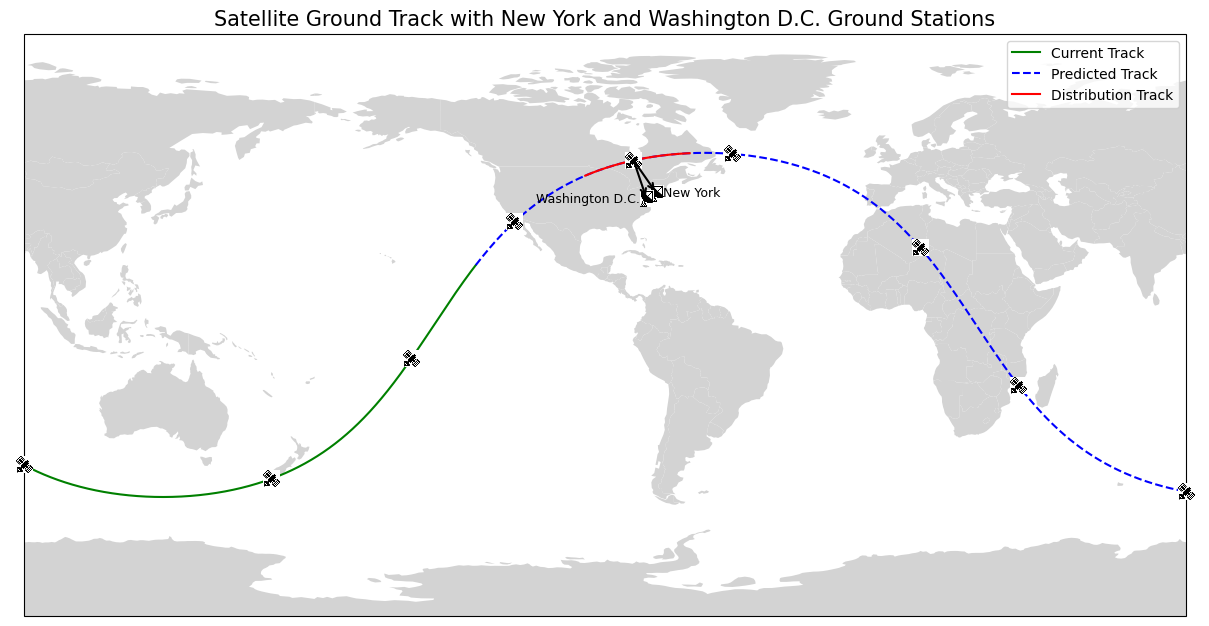

In [42]:
# Create a figure and axis with a Cartopy projection centered on -90 degrees (Americas)
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-90)})

# Plot the world map using GeoPandas with the specified projection
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', transform=ccrs.PlateCarree())

# Combine the current and predicted tracks
combined_latitudes = filtered_latitudes_observed + filtered_latitudes_predicted
combined_longitudes = filtered_longitudes_observed + filtered_longitudes_predicted

# Plot the current satellite ground track (blue solid line)
ax.plot(filtered_longitudes_observed, filtered_latitudes_observed, color='green', linewidth=1.5, label='Current Track', transform=ccrs.Geodetic())

# Plot the predicted satellite ground track (yellow dashed line)
ax.plot(filtered_longitudes_predicted, filtered_latitudes_predicted, color='blue', linewidth=1.5, linestyle='--', label='Predicted Track', transform=ccrs.Geodetic())

# Plot the distribution track (where eta > 0.00001 for both stations) as a red solid line
ax.plot(filtered_longitudes_distribution, filtered_latitudes_distribution, color='red', linewidth=1.5, label='Distribution Track', transform=ccrs.Geodetic())
# Add ground station icons with correct alignment
for station, data in ground_stations.items():
    image_box = OffsetImage(ground_station_icon, zoom=0.05)  # Adjust zoom as needed
    ab = AnnotationBbox(image_box, (data['longitude'], data['latitude']), frameon=False, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax))
    ax.add_artist(ab)
    # Adjust label positions manually
    if station == "New York":
        ax.text(data['longitude'] + 2, data['latitude'] - 1, station, transform=ccrs.PlateCarree(), fontsize=9, ha='left')
    else:
        ax.text(data['longitude'] - 2, data['latitude'] - 1, station, transform=ccrs.PlateCarree(), fontsize=9, ha='right')

# Place satellite icons evenly along the combined track
num_satellites = 8  # Number of satellites to place
satellite_indices = np.linspace(0, len(combined_longitudes) - 1, num_satellites, dtype=int)

for i in satellite_indices:
    image_box = OffsetImage(satellite_icon, zoom=0.05)  # Adjust zoom as needed
    ab = AnnotationBbox(image_box, (combined_longitudes[i], combined_latitudes[i]), frameon=False, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax))
    ax.add_artist(ab)

# Add a single satellite icon on the distribution track
if filtered_longitudes_distribution:
    index = len(filtered_longitudes_distribution) // 2  # Middle of the distribution track
    image_box = OffsetImage(satellite_icon, zoom=0.05)  # Adjust zoom as needed
    ab = AnnotationBbox(image_box, (filtered_longitudes_distribution[index], filtered_latitudes_distribution[index]), frameon=False, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax))
    ax.add_artist(ab)

    # Add arrows pointing to ground stations from the satellite on the distribution track
    for station, data in ground_stations.items():
        ax.annotate(
            '', 
            xy=(data['longitude'], data['latitude']), 
            xytext=(filtered_longitudes_distribution[index], filtered_latitudes_distribution[index]),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            transform=ccrs.PlateCarree()
        )

# Add title and labels
ax.set_title('Satellite Ground Track with New York and Washington D.C. Ground Stations', fontsize=15)
ax.legend()

# Show the plot
plt.show()

In [60]:
# Adjust longitudes to account for the new map center at -90 degrees
adjusted_longitudes = [(lon - 360) + 90 if lon > 90 else lon + 90 for lon in satellite_longitudes]

# Initialize lists for filtered latitudes and longitudes
filtered_latitudes_observed = []
filtered_longitudes_observed = []
filtered_latitudes_predicted = []
filtered_longitudes_predicted = []
filtered_latitudes_distribution = []
filtered_longitudes_distribution = []

# Loop to find a segment where the satellite moves from left to right (increasing adjusted longitude)
for i in range(1, len(adjusted_longitudes)):
    if adjusted_longitudes[i] > adjusted_longitudes[i - 1]:
        if adjusted_longitudes[i] <= -20:  # Corresponds to original longitude -100 adjusted by +360
            filtered_latitudes_observed.append(satellite_latutudes[i])
            filtered_longitudes_observed.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i]*etas_washington_dc[i] > 1e-9 :
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
        else:  # Predicted track after original longitude -100 adjusted
            filtered_latitudes_predicted.append(satellite_latutudes[i])
            filtered_longitudes_predicted.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i]*etas_washington_dc[i] > 1e-9 :
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
    else:
        # Check if both observed and predicted segments are non-empty and reset if needed
        if len(filtered_longitudes_observed) == 0 or filtered_longitudes_observed[0] + 90 - 360 > -170:
            filtered_latitudes_observed = []
            filtered_longitudes_observed = []
            filtered_latitudes_predicted = []
            filtered_longitudes_predicted = []
            filtered_latitudes_distribution = []
            filtered_longitudes_distribution = []
        else:
            break



C:\Users\ycgao\AppData\Local\Temp\ipykernel_23608\730869572.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


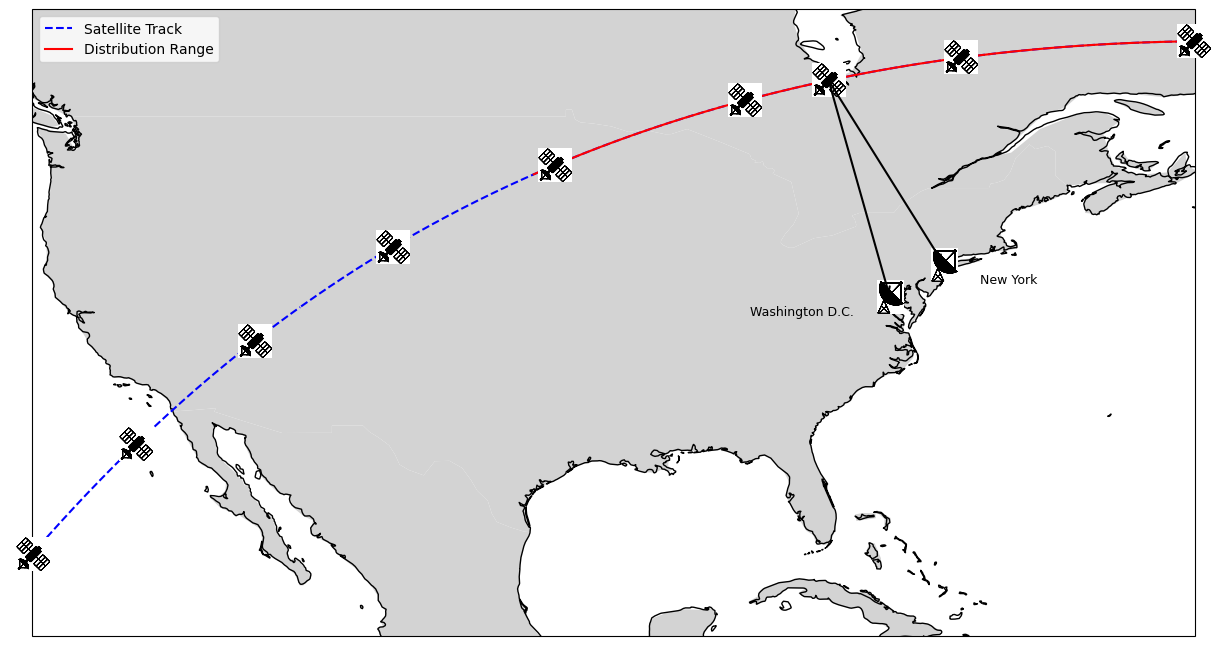

In [59]:
# Function to clip tracks based on the map's extents
def clip_tracks(longitudes, latitudes, extent):
    lon_min, lon_max, lat_min, lat_max = extent
    clipped_lons, clipped_lats = [], []
    for lon, lat in zip(longitudes, latitudes):
        if lon_min <= lon <= lon_max and lat_min <= lat <= lat_max:
            clipped_lons.append(lon)
            clipped_lats.append(lat)
    return clipped_lons, clipped_lats

# Define the map extent
map_extent = [-125, -60, 20, 55]  # Customize this as needed


# Clipping the tracks based on the defined extent
filtered_longitudes_observed, filtered_latitudes_observed = clip_tracks(filtered_longitudes_observed, filtered_latitudes_observed, map_extent)
filtered_longitudes_predicted, filtered_latitudes_predicted = clip_tracks(filtered_longitudes_predicted, filtered_latitudes_predicted, map_extent)
filtered_longitudes_distribution, filtered_latitudes_distribution = clip_tracks(filtered_longitudes_distribution, filtered_latitudes_distribution, map_extent)


# Set the map extent to focus on North America
ax.set_extent(map_extent, crs=ccrs.PlateCarree())


# Create a figure and axis with a Cartopy projection centered on -90 degrees (Americas)
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-90)})




# Plot the world map using GeoPandas with the specified projection
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', transform=ccrs.PlateCarree())
#world.boundary.plot(ax=ax, transform=ccrs.PlateCarree())


# Combine the current and predicted tracks
combined_latitudes = filtered_latitudes_observed + filtered_latitudes_predicted
combined_longitudes = filtered_longitudes_observed + filtered_longitudes_predicted

# Plot the clipped tracks
ax.plot(filtered_longitudes_observed, filtered_latitudes_observed, color='blue', linewidth=1.5, linestyle='--', transform=ccrs.Geodetic())
ax.plot(filtered_longitudes_predicted, filtered_latitudes_predicted, color='blue', linewidth=1.5, linestyle='--', label='Satellite Track', transform=ccrs.Geodetic())
ax.plot(filtered_longitudes_distribution, filtered_latitudes_distribution, color='red', linewidth=1.5, label='Distribution Range', transform=ccrs.Geodetic())

# Set the extent to focus on North America, especially around the distribution track
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

# Add ground station icons with correct alignment
for station, data in ground_stations.items():
    image_box = OffsetImage(ground_station_icon, zoom=0.1)  # Adjust zoom as needed
    ab = AnnotationBbox(image_box, (data['longitude'], data['latitude']), frameon=False, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax))
    ax.add_artist(ab)
    # Adjust label positions manually
    if station == "New York":
        ax.text(data['longitude'] + 2, data['latitude'] - 1, station, transform=ccrs.PlateCarree(), fontsize=9, ha='left')
    else:
        ax.text(data['longitude'] - 2, data['latitude'] - 1, station, transform=ccrs.PlateCarree(), fontsize=9, ha='right')

# Place satellite icons evenly along the combined track
num_satellites = 8  # Number of satellites to place
satellite_indices = np.linspace(0, len(combined_longitudes) - 1, num_satellites, dtype=int)

for i in satellite_indices:
    image_box = OffsetImage(satellite_icon, zoom=0.1)  # Adjust zoom as needed
    ab = AnnotationBbox(image_box, (combined_longitudes[i], combined_latitudes[i]), frameon=False, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax))
    ax.add_artist(ab)

# Add a single satellite icon on the distribution track
if filtered_longitudes_distribution:
    index = len(filtered_longitudes_distribution) // 2  # Middle of the distribution track
    image_box = OffsetImage(satellite_icon, zoom=0.1)  # Adjust zoom as needed
    ab = AnnotationBbox(image_box, (filtered_longitudes_distribution[index], filtered_latitudes_distribution[index]), frameon=False, xycoords=ccrs.PlateCarree()._as_mpl_transform(ax))
    ax.add_artist(ab)

    # Add arrows pointing to ground stations from the satellite on the distribution track
    for station, data in ground_stations.items():
        ax.annotate(
            '', 
            xy=(data['longitude'], data['latitude']), 
            xytext=(filtered_longitudes_distribution[index], filtered_latitudes_distribution[index]),
            arrowprops=dict(arrowstyle="->", color='black', lw=1.5),
            transform=ccrs.PlateCarree()
        )
# Add coastlines and gridlines for better context
ax.coastlines()
#ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

# Add title and labels
#ax.set_title('Satellite Ground Track with New York and Washington D.C. Ground Stations', fontsize=15)
ax.legend()

# Show the plot
plt.show()